In [1]:
from skddp_se.model.kurtosis import SegKurtosis
import torchaudio
import matplotlib.pyplot as plt
import torch
import random
from pathlib import Path

In [2]:
Power_STFT = torchaudio.transforms.Spectrogram(
    n_fft=512,
    hop_length=128,
    power=2
)

seg_settings = [
    (8, 8), # (freq, time)
    (32, 2),
    (2, 32)
]
seg_kurtosis_modules = [SegKurtosis(kernel=seg_setting, shift=seg_setting) for seg_setting in seg_settings]

speech_folder = Path("./corpus/LJSpeech-1.1/wavs/")
noise_folder = Path("./corpus/DEMAND/")

Speech file: corpus/LJSpeech-1.1/wavs/LJ013-0122.wav
Noise file: corpus/DEMAND/PSTATION/ch16.wav
Segment setting: (8, 8)
Speech kurtosis: 12.612817764282227
Noise kurtosis: 6.251044273376465
Noisy speech kurtosis: 8.004786491394043


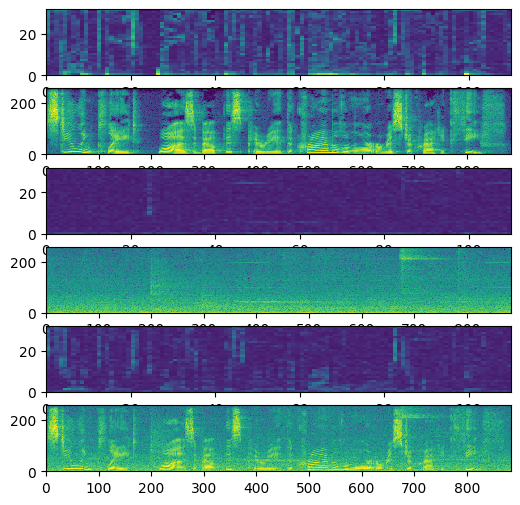

Segment setting: (32, 2)
Speech kurtosis: 14.311692237854004
Noise kurtosis: 7.472301959991455
Noisy speech kurtosis: 9.190401077270508


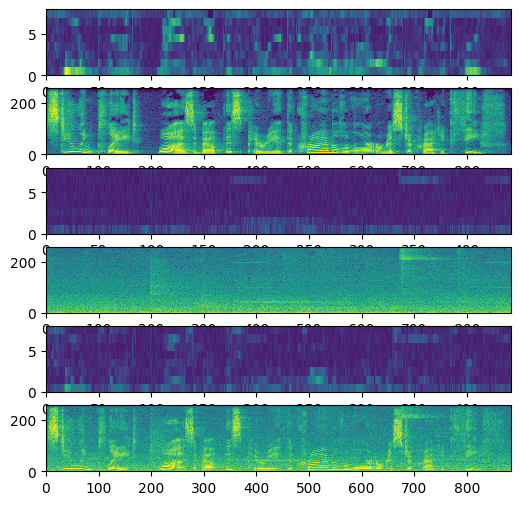

Segment setting: (2, 32)
Speech kurtosis: 21.17405891418457
Noise kurtosis: 6.155534744262695
Noisy speech kurtosis: 11.037426948547363


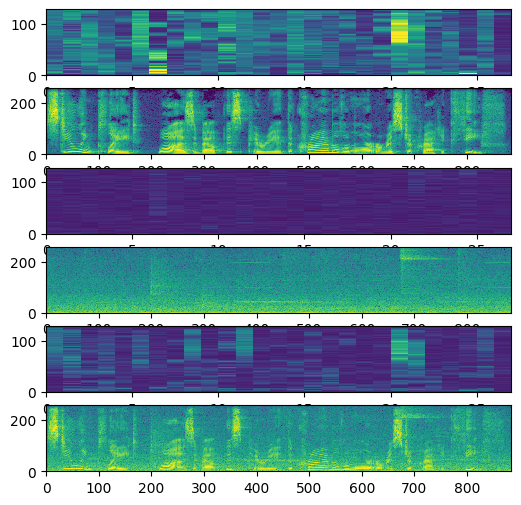

In [4]:
# load example audio
# random sampling
speech_file = random.choice(list(speech_folder.glob("*.wav")))
noise_file = random.choice(list(noise_folder.glob("*/*.wav")))
speech, sr = torchaudio.load(speech_file)
noise, sr = torchaudio.load(noise_file)
print(f"Speech file: {speech_file}")
print(f"Noise file: {noise_file}")
# random crop
start_idx = random.randint(0, noise.size(1) - speech.size(1))
noise = noise[:, start_idx:start_idx + speech.size(1)]

for i, seg_setting, kurtosis_module in zip(range(3), seg_settings, seg_kurtosis_modules):
    print(f"Segment setting: {seg_setting}")
    fig, axes = plt.subplots(6,1, figsize=(6, 6))
    noisy_speech = torchaudio.functional.add_noise(speech, noise, snr=torch.tensor([10]))
    noise = noisy_speech - speech
    speech_spec, noise_spec, noisy_speech_spec = Power_STFT(speech), Power_STFT(noise), Power_STFT(noisy_speech)
    speech_kurt, noise_kurt, noisy_speech_kurt = \
        kurtosis_module(speech_spec.unsqueeze(0)), \
            kurtosis_module(noise_spec.unsqueeze(0)), \
                kurtosis_module(noisy_speech_spec.unsqueeze(0))
    print(f"Speech kurtosis: {speech_kurt.mean().item()}")
    print(f"Noise kurtosis: {noise_kurt.mean().item()}")
    print(f"Noisy speech kurtosis: {noisy_speech_kurt.mean().item()}")
    t = torch.linspace(0, speech_kurt.size(2), speech_kurt.size(2))
    t = t / sr
    f = torch.linspace(0, speech_kurt.size(1), speech_kurt.size(1))
    f = f / speech_kurt.size(1) * sr / 2
    axes[0].pcolormesh(speech_kurt[0,0].numpy(), vmin=0, vmax=60)
    axes[1].pcolormesh(10 * torch.log10(speech_spec[0]), vmin=-80, vmax=20)
    axes[2].pcolormesh(noise_kurt[0,0].numpy(), vmin=0, vmax=60)
    axes[3].pcolormesh(10 * torch.log10(noise_spec[0]), vmin=-80, vmax=20)
    axes[4].pcolormesh(noisy_speech_kurt[0,0].numpy(), vmin=0, vmax=60)
    axes[5].pcolormesh(10 * torch.log10(noisy_speech_spec[0]), vmin=-80, vmax=20)
    plt.show()